In [21]:
import os
import sys
from pathlib import Path
import argparse
from tqdm import tqdm
sys.path.append(os.getcwd())

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

from sklearn import metrics

from pytorchcv.model_provider import get_model

from loss_functions import AAML, AdditiveAngularMarginLoss, CircleLoss, RBFClassifier
from train import USE_SLURM, Model, ModelArc
from data_load import get_loader, get_channels, get_num_classes

from evaluation import get_values_from_path, create_model, get_device, get_embs, calc_means, get_shortest_dist, calc_ber, cos_sim

In [44]:
path = "./model/arcface_resnet18_cifar10_512embs_sgd_200ep_64bs_0.00035lr_m05s64_9.pt"
ev_ds = "noise"

print(path)
print(ev_ds)

values = get_values_from_path(path)

print("Load Model")
model = create_model(values)
device = get_device()
model.to(device)
model.load_state_dict(torch.load(path)["model_state_dict"])
model.eval()

print("Get Data")
trainloader, testloader_train = get_loader(bs=values["bs"], dataset=values["dataset"], USE_SLURM=USE_SLURM)
_, testloader_eval = get_loader(bs=values["bs"], dataset=ev_ds, USE_SLURM=USE_SLURM)

/results_nas/erka8345/checkpoints/arcface_resnet18_cifar10_512embs_sgd_200ep_64bs_0.00035lr_m05s64_9.pt
noise
Load Model
Get Data
Files already downloaded and verified
Files already downloaded and verified


In [45]:
print("Calculate Embeddings")
embs_traindata, ys_traindata = get_embs(model, trainloader)
embs_train, ys_train = get_embs(model, testloader_train)
embs_eval, ys_eval = get_embs(model, testloader_eval)

  0%|          | 2/782 [00:00<01:00, 12.83it/s]

Calculate Embeddings


100%|██████████| 157/157 [00:13<00:00, 11.65it/s]


In [46]:
# 1. calc means for all labels
print("Calculate means")
means = calc_means(embs_traindata, ys_traindata)

# 2. get shortest distance between emb and mean
print("Get shortest distances...")
print("...of ID test data...")
real_id_dist = np.array([])
for emb in tqdm(embs_train):
    sh_dist, _ = get_shortest_dist(emb, means)
    real_id_dist = np.append(real_id_dist, sh_dist.cpu())
y_true = np.zeros(len(real_id_dist))
#print(real_id_dist.shape)
#print(y_true.shape)
print("Mean ID angle: ",real_id_dist.mean())

print("...of ID train data...")
test_id_dist = np.array([])
for emb in tqdm(embs_traindata):
    sh_dist, _ = get_shortest_dist(emb, means)
    test_id_dist = np.append(test_id_dist, sh_dist.cpu())

  1%|          | 59/10000 [00:00<00:16, 585.60it/s]

Calculate means
Get shortest distances...
...of ID test data...


  0%|          | 14/50000 [00:00<06:01, 138.14it/s]

Mean ID angle:  21.2919314678669
...of ID train data...


100%|██████████| 50000/50000 [01:10<00:00, 710.42it/s]


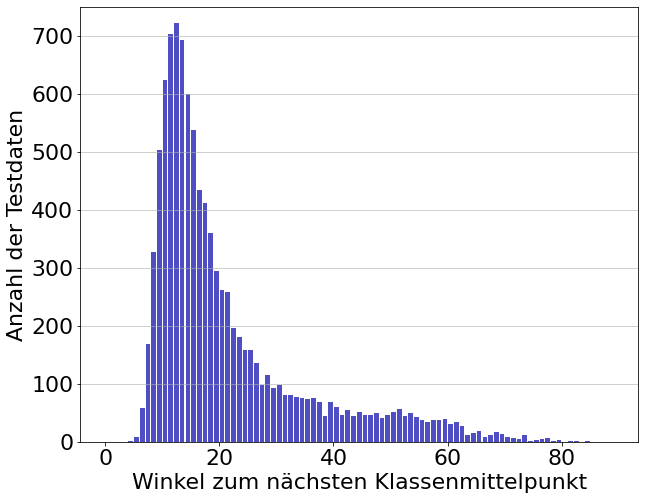

In [51]:
%matplotlib inline
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 22})
plt.hist(real_id_dist, bins=np.arange(90), color='#0504aa',alpha=0.7, rwidth=0.82)
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Winkel zum nächsten Klassenmittelpunkt")
plt.ylim([0, 750])
plt.ylabel("Anzahl der Testdaten")
plt.show()

In [48]:
#m = means[0]
#print(m)
avg_sum_all = 0
for m in means:
    avg_sum = 0
    for idx, mean in enumerate(means):
        dist = cos_sim(m.unsqueeze(0), mean.unsqueeze(0))
        dist = torch.acos(dist)
        dist = torch.rad2deg(dist)
        #print(dist)
        avg_sum += dist
    print(avg_sum/9)
    avg_sum_all += avg_sum/9
print(avg_sum_all/10)

tensor([92.9895], device='cuda:0')
tensor([87.8892], device='cuda:0')
tensor([94.1753], device='cuda:0')
tensor([94.3962], device='cuda:0')
tensor([93.6955], device='cuda:0')
tensor([92.2069], device='cuda:0')
tensor([88.0058], device='cuda:0')
tensor([89.3148], device='cuda:0')
tensor([93.0103], device='cuda:0')
tensor([88.8670], device='cuda:0')
tensor([91.4550], device='cuda:0')


### Distance in angle
RBF -> 96.3632 \
Softmax -> 96.3340 \
Circle -> 96.2880 \
AAML -> 91.4550

In [6]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [7]:
ev_ds = "svhn"

_, testloader_eval = get_loader(bs=values["bs"], dataset=ev_ds, USE_SLURM=USE_SLURM)
embs_eval, ys_eval = get_embs(model, testloader_eval)
print(embs_eval.shape)
embs_eval = embs_eval[:10000]
print(embs_eval.shape)

print("...of OOD test data...")
real_ood_dist = np.array([])
for emb in tqdm(embs_eval):
    sh_dist, _ = get_shortest_dist(emb, means)
    real_ood_dist = np.append(real_ood_dist, sh_dist.cpu())
y_false = np.ones(len(real_ood_dist))

Using downloaded and verified file: /results_nas/erka8345/data/test_32x32.mat


  0%|          | 32/10000 [00:00<00:31, 316.43it/s]

torch.Size([26032, 512])
torch.Size([10000, 512])
...of OOD test data...


100%|██████████| 10000/10000 [00:14<00:00, 682.13it/s]


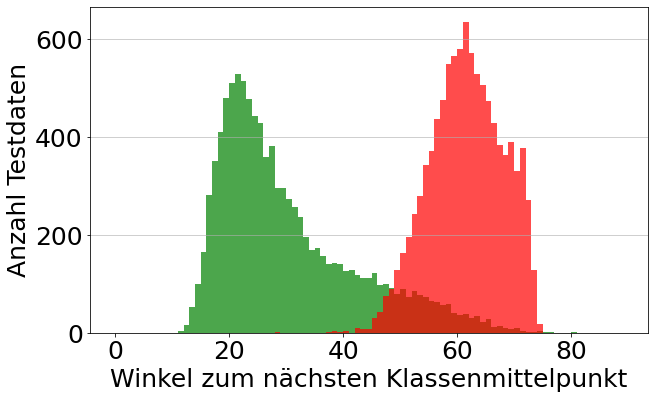

In [8]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 25})
plt.hist(real_id_dist, bins=np.arange(90), color='green',alpha=0.7, rwidth=1.0)
plt.hist(real_ood_dist, bins=np.arange(90), color='red',alpha=0.7, rwidth=1.0)
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Winkel zum nächsten Klassenmittelpunkt")
plt.ylabel("Anzahl Testdaten")
plt.show()

In [9]:
dist_scores = np.append(real_id_dist, real_ood_dist)
y = np.append(y_true, y_false)
#print(dist_scores.shape)
#print(y.shape)

# print(real_ood_dist, real_ood_dist.shape)

# 3. calc roc and auroc
fpr, tpr, thresholds = metrics.roc_curve(y, dist_scores)
roc_score = metrics.roc_auc_score(y, dist_scores)

min_ber = np.min(calc_ber(tpr,fpr))
argmin_ber = np.argmin(calc_ber(tpr,fpr))
print(f"Minimum BER: {min_ber}")
print(f"   Threshold: {thresholds[argmin_ber]}")


# print(fpr, fpr.shape)
# print(tpr, tpr.shape)
# print(thresholds, thresholds.shape)
print(f"AUROC: {roc_score}")

from sklearn.metrics import auc

precision, recall, thresholds = metrics.precision_recall_curve(y, dist_scores)

pr_score = auc(recall, precision)
print(f"AUPR: {pr_score}")


Minimum BER: 0.06399999999999997
   Threshold: 48.49132537841797
AUROC: 0.9717401099999999
AUPR: 0.9556296601841321


In [ ]:
def get_softmax_max(model, dl, need_label):
    softmax = nn.Softmax(dim=1)
    values = torch.Tensor([]).to(get_device())
    device = get_device()
    for img, t in dl:
        with torch.no_grad():
            img, t = img.to(device), t.to(device)
            if need_label:
                pred = model(img,t)
            else:
                pred = model(img)
            sm_value = softmax(pred)
            max_value = torch.max(sm_value) 
            values = torch.cat((values, max_value.unsqueeze(0)))
    return values

In [18]:
need_label = False
if (values["loss"]=="circle")|(values["loss"]=="arcface"):
    need_label = True
trainloader, testloader_train = get_loader(bs=1, dataset=values["dataset"], USE_SLURM=USE_SLURM)
id_sm_values = get_softmax_max(model, testloader_train, need_label)
id_sm_values = id_sm_values.to("cpu").numpy()

Files already downloaded and verified
Files already downloaded and verified
